# Nash Q learning basic implementation

In [2]:
import numpy as np
import nashpy as nash

In [3]:
Q = 4#Number of games
N = 2 #Number of players
A = 2 #Number of actions per player

In [4]:
# Player1 action / Player2 action / starting state / ending state / probability
#Player 1 - column player - 0: .3, 1: .4
#Player 2 - row player - 0: .1, 1: .2
TRANSITION_MATRIX = np.array(
    [
        # Player 1 - Action 0
        [
            # Player 2 - Action 0 - .1 .3
            [
                
                [0, 0.5, 0, 0.5],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0.5, 0, 0, 0.5]
                
            ],

            # Player 2 - Action 1 .2 .3
            [
                
                [1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [0.5, 0, 0, 0.5]
                
            ]
        ],

        # Player 1 - Action 1
        [
            # Player 2 - Action 0 .1 .4
            [
                
                [1, 0, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 0, 1],
                [0.5, 0, 0, 0.5]
                
            ],

            # Player 2 - Action 1 .2 .4
            [
                
                [0, 0.5, 0, 0.5],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [0.5, 0, 0, 0.5]
                
            ]
        ]
    ]
)

In [5]:
TRANSITION_MATRIX[0, 1, 2, 3]

1.0

In [6]:
# state / player1 action / player2 action / [player1 reward, player2 reward]
PAYOFF_MATRIX = np.array([
    # State 0
    [
        [ [2, 1], [0, 0] ],
        [ [0, 0], [1, 2] ]
    ],
    # State 1
    [
        [ [1, 1], [3, 0] ],
        [ [0, 3], [2, 2] ]
    ],
    # State 
    [
        [ [2, 0], [0, 2] ],
        [ [0, 1], [1, 0] ]
    ],
    # State 33
    [
        [ [1, 1], [0, 0] ],
        [ [0, 0], [2, 2] ]
    ],
])

In [7]:
PAYOFF_MATRIX[0, :, :, 0]

array([[2, 0],
       [0, 1]])

In [8]:
def transition_probability(state, player1_action, player2_action, next):
    return TRANSITION_MATRIX[player1_action, player2_action, state, next]

In [9]:
def reward(state, player1_action, player2_action):
    return PAYOFF_MATRIX[state, player1_action, player2_action]

In [10]:
state = 0
totalReward = np.array([0, 0])
n_games = 1000
for _ in range(n_games):
    print("State:", state)
    player1_action = np.random.choice(A, p=[0.5, 0.5])
    player2_action = np.random.choice(A, p=[0.5, 0.5])
    print("Player 1 action:", player1_action)
    print("Player 2 action:", player2_action)
    next_state = np.random.choice(range(Q), p=TRANSITION_MATRIX[player1_action, player2_action, state])
    print("Next state:", next_state)
    r = reward(state, player1_action, player2_action)
    print("Reward:", r)
    state = next_state
    totalReward += r
print("Total reward:", totalReward / n_games)

State: 0
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [2 1]
State: 1
Player 1 action: 0
Player 2 action: 1
Next state: 2
Reward: [3 0]
State: 2
Player 1 action: 0
Player 2 action: 1
Next state: 3
Reward: [0 2]
State: 3
Player 1 action: 1
Player 2 action: 0
Next state: 3
Reward: [0 0]
State: 3
Player 1 action: 1
Player 2 action: 0
Next state: 3
Reward: [0 0]
State: 3
Player 1 action: 1
Player 2 action: 1
Next state: 0
Reward: [2 2]
State: 0
Player 1 action: 1
Player 2 action: 0
Next state: 0
Reward: [0 0]
State: 0
Player 1 action: 0
Player 2 action: 1
Next state: 0
Reward: [0 0]
State: 0
Player 1 action: 1
Player 2 action: 1
Next state: 1
Reward: [1 2]
State: 1
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Player 1 action: 1
Player 2 action: 0
Next state: 3
Reward: [0 3]
State: 3
Player 1 action: 0
Player 2 action: 1
Next state: 3
Reward: [0 0]
State: 3
Player 1 action:

In [11]:
def computeNashEq(state, payoff_matrix):
    game = nash.Game(payoff_matrix[state, :, :, 0], PAYOFF_MATRIX[state, :, :, 1])
    eqs = game.vertex_enumeration()

    try:
        eq = next(eqs)
        return eq
    except StopIteration:
        a = np.random.rand()
        b = np.random.rand()
        return [[a, 1 - a], [b, 1 - b]]
    

In [12]:
computeNashEq(3, PAYOFF_MATRIX)

(array([0., 1.]), array([0., 1.]))

In [13]:
#Simulate plays with nash policy
state = 0
totalReward = np.array([0, 0])
for _ in range(n_games):
    print("State:", state)
    nashEq = computeNashEq(state, PAYOFF_MATRIX)
    print("Nash equilibrium:", nashEq)
    player1_action = np.random.choice(A, p=nashEq[0])
    player2_action = np.random.choice(A, p=nashEq[1])
    print("Player 1 action:", player1_action)
    print("Player 2 action:", player2_action)
    next_state = np.random.choice(range(Q), p=TRANSITION_MATRIX[player1_action, player2_action, state])
    print("Next state:", next_state)
    r = reward(state, player1_action, player2_action)
    print("Reward:", r)
    state = next_state
    totalReward += r
print("Total reward:", totalReward/n_games)

State: 0
Nash equilibrium: (array([0., 1.]), array([0., 1.]))
Player 1 action: 1
Player 2 action: 1
Next state: 1
Reward: [1 2]
State: 1
Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1


Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
State: 1
Nash equilibrium: (array([1., 0.]), array([1., 0.]))
Player 1 action: 0
Player 2 action: 0
Next state: 1

In [14]:
qTable = np.zeros((Q, A, A, N))

In [15]:
computeNashEq(0, qTable)

C:\Users\Paolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nashpy\polytope\polytope.py:109: RuntimeWarning: divide by zero encountered in divide
  hs = HalfspaceIntersection(halfspaces, feasible_point)
C:\Users\Paolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nashpy\polytope\polytope.py:109: RuntimeWarning: invalid value encountered in divide
  hs = HalfspaceIntersection(halfspaces, feasible_point)


[[0.1123323784159036, 0.8876676215840964],
 [0.274774288142864, 0.725225711857136]]

In [16]:
def expectedPayoff(payoff_matrix, player1_strategy, player2_strategy):
    expected_payoff = np.dot(np.dot(player1_strategy, payoff_matrix), player2_strategy)
    return expected_payoff
    

In [17]:
print(PAYOFF_MATRIX[0, :, :])

[[[2 1]
  [0 0]]

 [[0 0]
  [1 2]]]


In [18]:
expectedPayoff(PAYOFF_MATRIX[2, :, :, 1], np.array([0.5, .5]), np.array([1, 0]))

0.5

In [51]:
#Simulate plays with nash policy
ALPHA = 0.5
GAMMA = 0.8
EPSILON = 0.1
n_games = 5000

qTable = np.zeros((Q, A, A, N))

state = 0
totalReward = np.array([0, 0])
diffs = []
expectedRewards = []

for _ in range(n_games):
    print("State:", state)
    nashEq = np.abs(computeNashEq(state, qTable))
    print("Nash equilibrium:", nashEq)
    player1_action = np.random.choice(A, p=nashEq[0]) if np.random.rand() > EPSILON else np.random.choice(A)
    player2_action = np.random.choice(A, p=nashEq[1]) if np.random.rand() > EPSILON else np.random.choice(A)
    print("Player 1 action:", player1_action)
    print("Player 2 action:", player2_action)
    next_state = np.random.choice(range(Q), p=TRANSITION_MATRIX[player1_action, player2_action, state])
    print("Next state:", next_state)
    r = reward(state, player1_action, player2_action)
    print("Reward:", r)

    next_NashEq = computeNashEq(next_state, qTable)
    next_qVal_0 = expectedPayoff(qTable[next_state, :, :, 0], next_NashEq[0], next_NashEq[1])
    next_qVal_1 = expectedPayoff(qTable[next_state, :, :, 1], next_NashEq[0], next_NashEq[1])

    oldQ = qTable[state, player1_action, player2_action].copy()

    qTable[state, player1_action, player2_action, 0] = (1 - ALPHA) * qTable[state, player1_action, player2_action, 0] + ALPHA * (r[0] + GAMMA * next_qVal_0)
    qTable[state, player1_action, player2_action, 1] = (1 - ALPHA) * qTable[state, player1_action, player2_action, 1] + ALPHA * (r[1] + GAMMA * next_qVal_1)
    
    diffs.append(qTable[state, player1_action, player2_action] - oldQ)

    print("QTable:", qTable[state])
    state = next_state
    totalReward += r
    expectedRewards.append(totalReward / (_ + 1))
print("Expected reward:", totalReward/n_games)
print("QTable:", qTable)

State: 0
Nash equilibrium: [[0.3048923  0.6951077 ]
 [0.79629182 0.20370818]]
Player 1 action: 1
Player 2 action: 0
Next state: 0
Reward: [0 0]
QTable: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
State: 0
Nash equilibrium: [[0.98989529 0.01010471]
 [0.29730659 0.70269341]]
Player 1 action: 0
Player 2 action: 1
Next state: 0
Reward: [0 0]
QTable: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
State: 0
Nash equilibrium: [[0.0294879  0.9705121 ]
 [0.73394019 0.26605981]]
Player 1 action: 1
Player 2 action: 0
Next state: 0
Reward: [0 0]
QTable: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
State: 0
Nash equilibrium: [[0.80282092 0.19717908]
 [0.92116299 0.07883701]]
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [2 1]
QTable: [[[1.  0.5]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]]]
State: 1
Nash equilibrium: [[0.3103629  0.6896371 ]
 [0.96498783 0.03501217]]
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
QTable: [[[0.5 0.5]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]]]
Stat

C:\Users\Paolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nashpy\polytope\polytope.py:109: RuntimeWarning: divide by zero encountered in divide
  hs = HalfspaceIntersection(halfspaces, feasible_point)
C:\Users\Paolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nashpy\polytope\polytope.py:109: RuntimeWarning: invalid value encountered in divide
  hs = HalfspaceIntersection(halfspaces, feasible_point)


QTable: [[[1.355 1.355]
  [0.    0.   ]]

 [[0.    1.5  ]
  [0.    0.   ]]]
State: 1
Nash equilibrium: [[1. 0.]
 [1. 0.]]
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
QTable: [[[1.7195 1.7195]
  [0.     0.    ]]

 [[0.     1.5   ]
  [0.     0.    ]]]
State: 1
Nash equilibrium: [[1. 0.]
 [1. 0.]]
Player 1 action: 0
Player 2 action: 0
Next state: 1
Reward: [1 1]
QTable: [[[2.04755 2.04755]
  [0.      0.     ]]

 [[0.      1.5    ]
  [0.      0.     ]]]
State: 1
Nash equilibrium: [[1. 0.]
 [1. 0.]]
Player 1 action: 0
Player 2 action: 1
Next state: 2
Reward: [3 0]
QTable: [[[2.04755 2.04755]
  [1.5     0.     ]]

 [[0.      1.5    ]
  [0.      0.     ]]]
State: 2
Nash equilibrium: [[0.62308709 0.37691291]
 [0.71292251 0.28707749]]
Player 1 action: 0
Player 2 action: 0
Next state: 2
Reward: [2 0]
QTable: [[[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
State: 2
Nash equilibrium: [[0.74307286 0.25692714]
 [0.44162569 0.55837431]]
Player 1 action: 0
Player 2 action: 0
Next sta

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
diffs = np.array(diffs)
print(diffs.shape)
diffs

expectedRewards = np.array(expectedRewards)

(5000, 2)


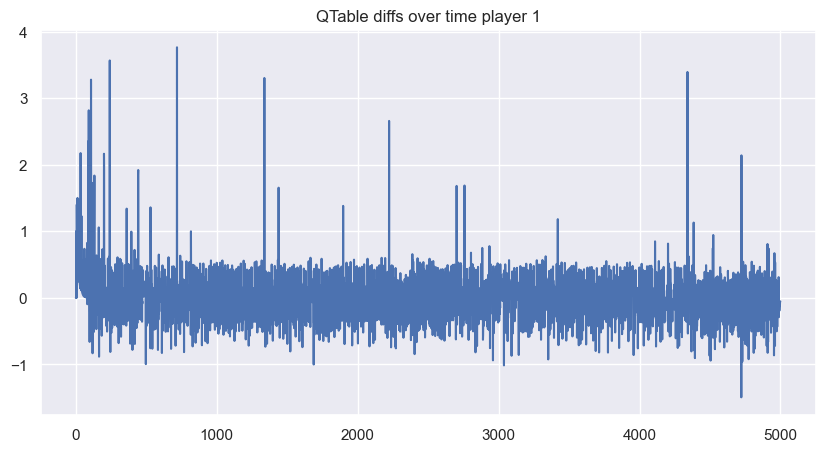

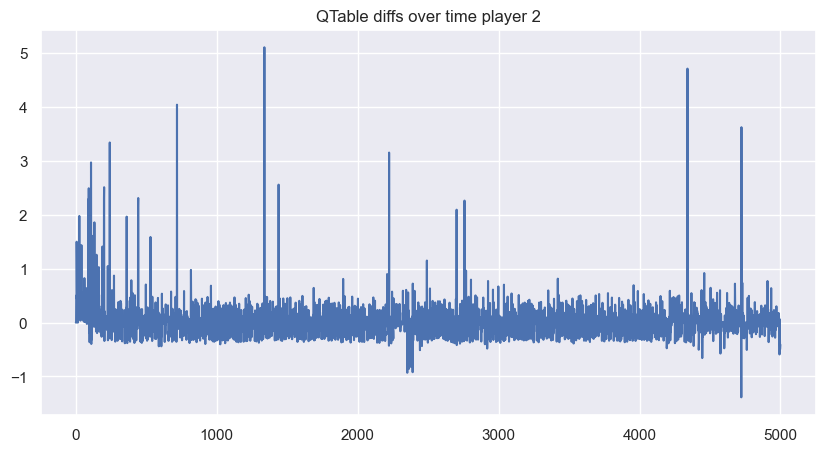

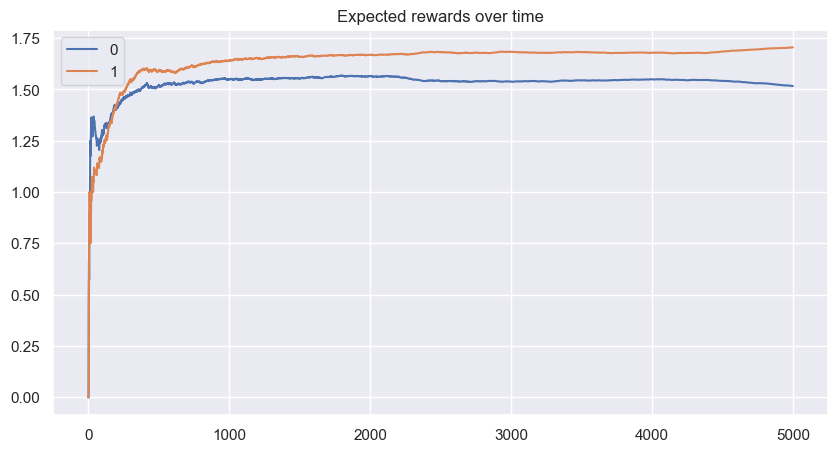

In [61]:
sns.set_theme()

plt.figure(figsize=(10, 5))
plt.title("QTable diffs over time player 1")
sns.lineplot(data=diffs[:, 0])
plt.show()

plt.figure(figsize=(10, 5))
plt.title("QTable diffs over time player 2")
sns.lineplot(data=diffs[:, 1])
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Expected rewards over time per player")
sns.lineplot(data=expectedRewards, dashes=False)
plt.show()